![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 6.4. Zero-Inflated Models

When analyzing count data, you may encounter datasets with excessive zeros. For example, a study on the number of doctor visits might have many individuals who reported zero visits in a given period. Traditional Poisson or negative binomial models struggle to handle this "zero inflation," often leading to poor fit and biased predictions. Zero-inflated models, such as the Zero-Inflated Poisson (ZIP) and Zero-Inflated Negative Binomial (ZINB), address this issue by modeling the excess zeros separately from the count process.

This tutorial introduces zero-inflated models in R, focusing on the ZIP and ZINB models. We'll start with an overview of these models, explaining how they account for excess zeros in count data. Then, we'll fit both models from scratch to understand their components, and we'll use the {pscl} package in R to streamline model fitting. Finally, we'll compare these models and evaluate prediction performance using test data to select the best-performing model.



## Overview
**Zero-inflated models** are statistical models designed to analyze count data with an excess of zeroes. These models are particularly useful when a dataset has more zero counts than would be expected under traditional count models like `Poisson` or `Negative Binomial distributions`. They are commonly used in fields like ecology, healthcare, economics, and social sciences, where it’s common to observe many zero values alongside non-zero counts.

***Why Use Zero-Inflated Models?***

In some datasets, zero counts occur so frequently that traditional count models (e.g., Poisson) fail to provide an accurate fit. Zero inflation can arise due to two types of zeroes:

1. **Structural Zeroes**: These occur because some units in the data have no chance of experiencing the event of interest. For example, in a survey on smoking habits, non-smokers will have a structural zero count for cigarette consumption.

2. **Sampling Zeroes**: These are regular zeroes that occur naturally in the data as part of the random process. For example, even smokers may occasionally have a zero count for the number of cigarettes smoked on a particular day.

Zero-inflated models account for both types by combining two processes:

- A **binary model** (often logistic regression) that models the probability of a structural zero.

- A **count model** (often Poisson or Negative Binomial) for the non-zero counts.

***How Zero-Inflated Models Work***

Zero-inflated models typically involve two components:

1. **Zero-inflation Component**: This component models the probability of an observation being in the "always-zero" group, using a logistic (or similar) regression model.

2. **Count Component**: This component models the count for non-zero values using either a Poisson or Negative Binomial distribution.

The two most common types of zero-inflated models are:

- **Zero-Inflated Poisson (ZIP)**: Assumes that the non-zero counts follow a Poisson distribution. Used when data do not exhibit overdispersion (variance ≈ mean).

- **Zero-Inflated Negative Binomial (ZINB)**: Assumes that non-zero counts follow a Negative Binomial distribution. Used when data exhibit overdispersion (variance > mean).


For a zero-inflated model, the probability of observing a count \( Y = y \) is given by:

$$ P(Y = y) =
\begin{cases}
      \pi + (1 - \pi) \cdot P(Y = 0 \,|\, \text{Count Model}) & \text{if } y = 0, \\
      (1 - \pi) \cdot P(Y = y \,|\, \text{Count Model}) & \text{if } y > 0.
\end{cases} $$

where:

- $\pi$ is the probability that an observation is in the `structural zero` state.

- $P(Y = y \,|\, \text{Count Model})$ represents the probability of observing count \( y \) under a `Poisson` or `Negative Binomial model`.

***When to Use Zero-Inflated Models***

Zero-inflated models are suitable when:

- **Data have an excess of zeroes** that cannot be explained by standard Poisson or Negative Binomial models.

- **Two distinct processes** are likely at play: one that generates structural zeroes and another that generates counts (including zeroes).

- The data may be **overdispersed** (in the case of ZINB).

***Examples of Zero-Inflated Models in Use***

1. **Healthcare**: Modeling the frequency of hospital visits, where some individuals never require a visit (structural zeroes) and others may have occasional visits.
2. **Ecology**: Modeling species count data in different regions where certain areas may not support the species at all (structural zeroes) and others may support varying counts.
3. **Economics**: Modeling loan defaults, where some individuals are unlikely to default at all (structural zeroes), while others have a probability of defaulting.


## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314969 sha256=a7da6d626ca163afdc07eea889008ca5f3a11202ceb0f2091ab3839e210b205a
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Check and install required R packages

In [ ]:
%%R
pkg <- c('tidyverse',
     'plyr',
		 'gt',
		 'DataExplorer',
		 'rstatix',
		 'gtsummary',
		 'report',
		 'performance',
		 'jtools',
		 'margins',
		 'marginaleffects',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'caret',
		 'tidymodels',
		 'metrica',
		 'RColorBrewer',
    'MASS',
    'epiDisplay',
		 'pscl',
		 'VGAM',
		 'AER'
		  )
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

## Fit Zero-Inflated Poisson Models

Here we’ll go through the steps to fit a Zero-Inflated Poisson (ZIP) model manually in R using a dataset that has zero-inflated count data. We’ll explore using the maximum likelihood estimation (MLE) method to estimate the parameters of the ZIP model.


### Generate Sample Zero-Inflated Data
Let's start by simulating data that includes zero inflation

In [ ]:
%%R
# set seed
set.seed(123)  # For reproducibility

# Define parameters for data generation
n <- 1000        # Sample size
pi_zero <- 0.4   # Probability of a structural zero
lambda <- 2      # Mean of the Poisson distribution for non-zero counts

# Generate zero-inflated Poisson data
data <- rpois(n, lambda)
is_zero_inflated <- rbinom(n, 1, pi_zero)  # Determines which entries are inflated zeroes

# Set values to zero based on zero-inflation
data[is_zero_inflated == 1] <- 0

# Display a summary of the generated data
table(data)

data
  0   1   2   3   4   5   6   8 
467 151 188 112  43  29   9   1 


This will generate a dataset with an excess of zeroes, approximating the kind of data we might analyze with a ZIP model.

###  Define the Log-Likelihood Function for the ZIP Model
The next step is to define the log-likelihood function of the ZIP model. This function calculates the likelihood of observing the data given the parameters $\pi$ and $\lambda$.

In [ ]:
%%R
# Define the log-likelihood function for the ZIP model
log_likelihood_zip <- function(params, data) {
  pi_zero <- params[1]     # Probability of zero-inflation
  lambda <- params[2]      # Mean of Poisson for non-zero counts

  # Calculate likelihood for zero counts
  zero_log_likelihood <- sum(log(pi_zero + (1 - pi_zero) * exp(-lambda)) * (data == 0))

  # Calculate likelihood for non-zero counts
  non_zero_log_likelihood <- sum(log((1 - pi_zero) * dpois(data[data > 0], lambda)))

  # Total log-likelihood
  total_log_likelihood <- zero_log_likelihood + non_zero_log_likelihood

  # Return negative log-likelihood (for minimization)
  return(-total_log_likelihood)
}

### Use Optim to Estimate Parameters
We can now use the `optim()` function to minimize the negative log-likelihood and estimate the parameters 𝜋 and 𝜆


In [ ]:
%%R
# Initial guesses for pi and lambda
initial_params <- c(0.3, 1.5)

# Estimate parameters by minimizing the negative log-likelihood
fit <- optim(par = initial_params, fn = log_likelihood_zip, data = data,
             method = "L-BFGS-B", lower = c(0.01, 0.01), upper = c(0.99, Inf))

# Display results
pi_estimate <- fit$par[1]
lambda_estimate <- fit$par[2]

cat("Estimated probability of zero-inflation (pi):", pi_estimate, "\n")
cat("Estimated Poisson mean (lambda):", lambda_estimate, "\n")


Estimated probability of zero-inflation (pi): 0.3856291 
Estimated Poisson mean (lambda): 2.02158 


Here, `optim()` finds the values of $\pi$ and $\lambda$ that maximize the likelihood of observing our data. We have set boundaries (lower and upper) for these parameters to ensure they stay within reasonable ranges.

###  Evaluate the Model Fit

To evaluate the fit, we can compare observed data with predicted values based on the estimated ZIP model parameters.

In [ ]:
%%R
#Predicted probabilities of zero and non-zero counts
predicted_zero_prob <- pi_estimate + (1 - pi_estimate) * exp(-lambda_estimate)
predicted_nonzero_mean <- (1 - pi_estimate) * lambda_estimate

cat("Predicted probability of zero:", predicted_zero_prob, "\n")
cat("Predicted mean of non-zero counts:", predicted_nonzero_mean, "\n")


Predicted probability of zero: 0.4670001 
Predicted mean of non-zero counts: 1.242 


## Fit Zero-Inflated Models with R

We’ll use the {pscl} package to fit a Zero-Inflated Poisson (ZIP) and Zero-Inflated Negative Binomial (ZINB) Model to data on physician office visits from the `NMES1988` dataset available in the {AER} package.

### Check and Install Required R Packages



In [3]:
%%R
packages <- c('tidyverse',
     'plyr',
	  'DataExplorer',
		 'dlookr',
		 'rstatix',
		 'gtsummary',
		 'performance',
		 'jtools',
		 'margins',
		 'marginaleffects',
		 'ggeffects',
		 'patchwork',
		 'Metrics',
		 'ggpmisc',
		 'epiDisplay',
		 'sandwich',
	   "AER",
	   "VGAM",
	   "MASS",
	   "pscl"
		  )

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [4]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method          from  
  plot.transform  scales
  print.transform scales

  method                  from   
  heightDetails.titleGrob ggplot2
  widthDetails.titleGrob  ggplot2



      tidyverse            plyr    DataExplorer          dlookr         rstatix 
           TRUE            TRUE            TRUE            TRUE            TRUE 
      gtsummary     performance          jtools         margins marginaleffects 
           TRUE            TRUE            TRUE            TRUE            TRUE 
      ggeffects       patchwork         Metrics         ggpmisc      epiDisplay 
           TRUE            TRUE            TRUE            TRUE            TRUE 
       sandwich             AER            VGAM            MASS            pscl 
           TRUE            TRUE            TRUE            TRUE            TRUE 


### Load R Packages

In [5]:
%%R
#%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages

Successfully loaded packages:
 [1] "package:pscl"            "package:VGAM"           
 [3] "package:splines"         "package:stats4"         
 [5] "package:AER"             "package:lmtest"         
 [7] "package:zoo"             "package:car"            
 [9] "package:carData"         "package:sandwich"       
[11] "package:epiDisplay"      "package:nnet"           
[13] "package:MASS"            "package:survival"       
[15] "package:foreign"         "package:ggpmisc"        
[17] "package:ggpp"            "package:Metrics"        
[19] "package:patchwork"       "package:ggeffects"      
[21] "package:marginaleffects" "package:margins"        
[23] "package:jtools"          "package:performance"    
[25] "package:gtsummary"       "package:rstatix"        
[27] "package:dlookr"          "package:DataExplorer"   
[29] "package:plyr"            "package:lubridate"      
[31] "package:forcats"         "package:stringr"        
[33] "package:dplyr"           "package:purrr"          
[

### Data

The physician office visits data set (**NMES1988**) from [AER](https://cran.r-project.org/web/packages/AER/index.html) package represents a sample of 4,406 individuals aged 66 and over who were covered by Medicare in 1988. One of the variables in the data is the number of physician `office visits`. If we want to create a model for the number of visits using some of the other variables in the dataset, we need to start by loading the data. You may also need to install the AER package.

A data frame containing 4,406 observations on 19 variables. We will use following variables:

-   visits- Number of physician office visits.
-   hospital - Number of hospital stays.
-   health - Factor indicating self-perceived health status, levels are "poor", "average" (reference category), "excellent".
-   chronic - Number of chronic conditions.
-   age - Age in years (divided by 10).
-   afam - Factor. Is the individual African-American?
-   gender - Factor indicating gender.
-   married- Factor. is the individual married?
-   school - Number of years of education.
-   income- Family income in USD 10,000.
-   employed - Factor. Is the individual employed?
-   insurance- Factor. Is the individual covered by private insurance?
-   medicaid Factor - Is the individual covered by Medicaid?

In [ ]:
%%R
# load the data
data("NMES1988", package = "AER")
# select variables
df<-NMES1988 |>
  dplyr::select(visits,
                hospital,
                health,
                chronic,
                age,
                afam,
                gender,
                married,
                school,
                income,
                employed,
                insurance,
                medicaid)  |>
  glimpse()

Rows: 4,406
Columns: 13
$ visits    <int> 5, 1, 13, 16, 3, 17, 9, 3, 1, 0, 0, 44, 2, 1, 19, 19, 0, 3, …
$ hospital  <int> 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, …
$ health    <fct> average, average, poor, poor, average, poor, average, averag…
$ chronic   <int> 2, 2, 4, 2, 2, 5, 0, 0, 0, 0, 1, 5, 1, 1, 1, 0, 1, 2, 3, 4, …
$ age       <dbl> 6.9, 7.4, 6.6, 7.6, 7.9, 6.6, 7.5, 8.7, 7.3, 7.8, 6.6, 6.9, …
$ afam      <fct> yes, no, yes, no, no, no, no, no, no, no, no, no, no, no, no…
$ gender    <fct> male, female, female, male, female, female, female, female, …
$ married   <fct> yes, yes, no, yes, yes, no, no, no, no, no, yes, yes, no, no…
$ school    <int> 6, 10, 10, 3, 6, 7, 8, 8, 8, 8, 8, 15, 8, 8, 12, 8, 8, 8, 10…
$ income    <dbl> 2.881000, 2.747800, 0.653200, 0.658800, 0.658800, 0.330100, …
$ employed  <fct> yes, no, no, no, no, no, no, no, no, no, yes, no, no, no, no…
$ insurance <fct> yes, yes, no, yes, yes, no, yes, yes, yes, yes, yes, yes, no…
$ medicaid  <fct

### Data Description

In [ ]:
%%R
df |>
  dplyr::summarise(across(visits,
                        ~ sum(is.na(.x) | .x == 0)))

  visits
1    683


The NMES1988 dataset includes several variables. The main variable of interest for the ZIP model is `visits`- the number of physician office visits, which is a count variable and has many zeroes (n = 683), making it suitable for zero-inflated modeling.

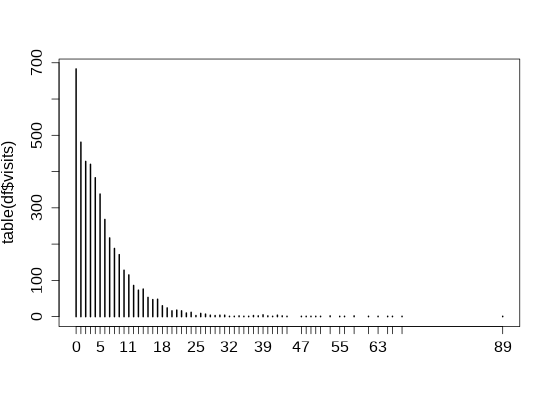

In [ ]:
%%R -w 550 -h 400 -u px
plot(table(df$visits))

### Descriptive Statistics

#### Gender

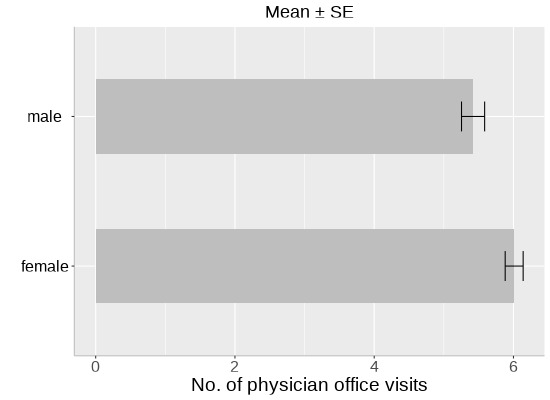

In [ ]:
%%R -w 550 -h 400 -u px
# Standard error
SE <- function(x){
  sd(x)/sqrt(length(x))
}

# Get summary statistics
summarise_gender<-plyr::ddply(df,~ gender, summarise,
                Mean= round(mean(visits), 2),
                Median=round (median(visits), 2),
                Min= round (min(visits),2),
                Max= round (max(visits),2),
                SD= round(sd(visits), 2),
                SE= round (SE(visits), 3))

# Barplot
ggplot(summarise_gender, aes(x=gender, y=Mean)) +
  geom_bar(stat="identity", position=position_dodge(),width=0.5, fill="gray") +
  geom_errorbar(aes(ymin=Mean-SE, ymax=Mean+SE), width=.2,
   position=position_dodge(.9))+
  # add y-axis title and x-axis title leave blank
  labs(y="No. of physician office visits", x = "")+
  # add plot title
  ggtitle("Mean ± SE ")+
  coord_flip()+
  # customize plot themes
  theme(
        axis.line = element_line(colour = "gray"),
        # plot title position at center
        plot.title = element_text(hjust = 0.5),
        # axis title font size
        axis.title.x = element_text(size = 14),
        # X and  axis font size
        axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5, colour='black'),
        axis.text.x = element_text(size=12))

#### African-American

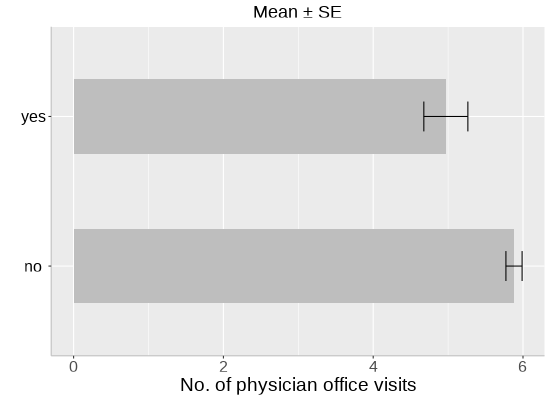

In [ ]:
%%R -w 550 -h 400 -u px
# Get summary statistics
summarise_afam<-plyr::ddply(df,~ afam, summarise,
                Mean= round(mean(visits), 2),
                Median=round (median(visits), 2),
                Min= round (min(visits),2),
                Max= round (max(visits),2),
                SD= round(sd(visits), 2),
                SE= round (SE(visits), 3))
# Barplot
ggplot(summarise_afam, aes(x=afam, y=Mean)) +
  geom_bar(stat="identity", position=position_dodge(),width=0.5, fill="gray") +
  geom_errorbar(aes(ymin=Mean-SE, ymax=Mean+SE), width=.2,
   position=position_dodge(.9))+
  # add y-axis title and x-axis title leave blank
  labs(y="No. of physician office visits", x = "")+
  # add plot title
  ggtitle("Mean ± SE")+
  coord_flip()+
  # customize plot themes
  theme(
        axis.line = element_line(colour = "gray"),
        # plot title position at center
        plot.title = element_text(hjust = 0.5),
        # axis title font size
        axis.title.x = element_text(size = 14),
        # X and  axis font size
        axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5, colour='black'),
        axis.text.x = element_text(size=12))

#### Self-perceived health status

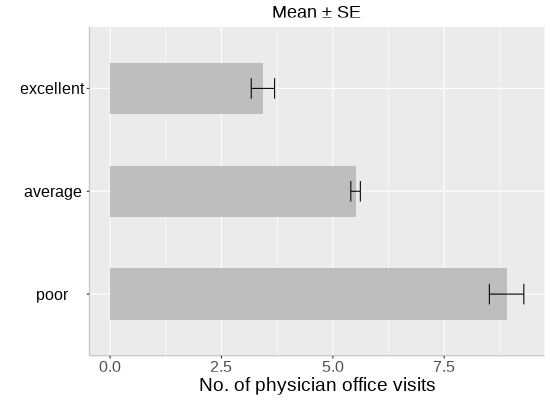

In [ ]:
%%R -w 550 -h 400 -u px
# Get summary statistics
summarise_health<-plyr::ddply(df,~ health, summarise,
                Mean= round(mean(visits), 2),
                Median=round (median(visits), 2),
                Min= round (min(visits),2),
                Max= round (max(visits),2),
                SD= round(sd(visits), 2),
                SE= round (SE(visits), 3))
# Barplot
ggplot(summarise_health, aes(x=health, y=Mean)) +
  geom_bar(stat="identity", position=position_dodge(),width=0.5, fill="gray") +
  geom_errorbar(aes(ymin=Mean-SE, ymax=Mean+SE), width=.2,
   position=position_dodge(.9))+
  # add y-axis title and x-axis title leave blank
  labs(y="No. of physician office visits", x = "")+
  # add plot title
  ggtitle("Mean ± SE")+
  coord_flip()+
  # customize plot themes
  theme(
        axis.line = element_line(colour = "gray"),
        # plot title position at center
        plot.title = element_text(hjust = 0.5),
        # axis title font size
        axis.title.x = element_text(size = 14),
        # X and  axis font size
        axis.text.y=element_text(size=12,vjust = 0.5, hjust=0.5, colour='black'),
        axis.text.x = element_text(size=12))

### Split Data

In [ ]:
%%R
# set seed
seeds = 11076
tr_prop = 0.70

# training data (70% data)
train= ddply(df,.(gender, afam),
                 function(., seed) { set.seed(seed); .[sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)
test = ddply(df, .(gender, afam),
            function(., seed) { set.seed(seed); .[-sample(1:nrow(.), trunc(nrow(.) * tr_prop)), ] }, seed = 101)

### Fit a Poisson Model

First we will a fit Poisson model with offset and check zero-inflation and overdispersion:


In [ ]:
%%R
fit.pois <- glm(
            visits  ~
                hospital +
                health +
                chronic +
                age +
                afam +
                gender +
                married +
                school +
                income +
                employed +
                insurance +
                medicaid,
                family = poisson(link = "log"),
                data = train)

Check for `zero-inflation` and `overdispersion`

In [ ]:
%%R
performance::check_overdispersion(fit.pois)
performance::check_zeroinflation(fit.pois)

# Check for zero-inflation

   Observed zeros: 488
  Predicted zeros: 37
            Ratio: 0.08



### Zero-Inflated Poisson (ZIP) Model

***ZIP*** model is suitable when the data have many zeros and there is no evidence of overdispersion in the count data (variance is roughly equal to the mean). The function `zeroinfl()` from {pscl} package can fit both ZIP with `dist = "poisson"` a Poisson distribution for the count part of the model.


In [ ]:
%%R
# Fit Zero-Inflated Poisson model with pscl package
fit.zip <- zeroinfl(visits  ~
                hospital +
                health +
                chronic +
                age +
                afam +
                gender +
                married +
                school +
                income +
                employed +
                insurance +
                medicaid,
                dist = "poisson",
                data = train)
# model summary
summary(fit.zip)


Call:
zeroinfl(formula = visits ~ hospital + health + chronic + age + afam + 
    gender + married + school + income + employed + insurance + medicaid, 
    data = train, dist = "poisson")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-4.5615 -1.1380 -0.4630  0.5494 19.3250 

Count model coefficients (poisson with log link):
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.918347   0.106340  18.040  < 2e-16 ***
hospital         0.152095   0.007312  20.800  < 2e-16 ***
healthpoor       0.214454   0.021580   9.938  < 2e-16 ***
healthexcellent -0.361330   0.038543  -9.375  < 2e-16 ***
chronic          0.091687   0.005865  15.633  < 2e-16 ***
age             -0.067137   0.013017  -5.158 2.50e-07 ***
afamyes         -0.013672   0.027026  -0.506  0.61295    
gendermale      -0.057218   0.017824  -3.210  0.00133 ** 
marriedyes      -0.074351   0.018253  -4.073 4.63e-05 ***
school           0.016576   0.002359   7.026 2.13e-12 ***
income          -0.

The `summary(fit.zip)` output includes coefficients for both parts of the ZIP model:

1.  **Count Model (Poisson Part)**:

    -   The coefficients for variables in this part explain the effects on the expected count of visits (for cases not in the zero-inflated group).

2.  **Zero-Inflation Model (Logistic Part)**:

    -   The coefficients for variables in this part reflect the likelihood of a structural zero (i.e., the probability that an individual has zero visits due to reasons not explained by the count model).

In [ ]:
%%R
performance::performance(fit.zip)

# Indices of model performance

AIC       |      AICc |       BIC |    R2 | R2 (adj.) |  RMSE | Sigma | Score_log | Score_spherical
---------------------------------------------------------------------------------------------------
22037.274 | 22037.805 | 22206.216 | 0.630 |     0.629 | 6.066 | 6.094 |    -3.565 |           0.013


### Zero-Inflated Negative Binomial (ZINB) Model

**ZINB** is used when there are both many zeros and overdispersion in the data (variance exceeds the mean significantly). The Negative Binomial model allows for greater flexibility when modeling count data with overdispersion. The function `zeroinfl()` from {pscl} package can fit both ZINB with `dist = "negbin"` a negative binomial for the count part of the model.

In [ ]:
%%R
# Fit Zero-Inflated Poisson model with VGM package
fit.zinb <-zeroinfl(visits  ~
                hospital +
                health +
                chronic +
                age +
                afam +
                gender +
                married +
                school +
                income +
                employed +
                insurance +
                medicaid,
                dist= "negbin",
                data = train)
# model summary
summary(fit.zinb)


Call:
zeroinfl(formula = visits ~ hospital + health + chronic + age + afam + 
    gender + married + school + income + employed + insurance + medicaid, 
    data = train, dist = "negbin")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-1.2291 -0.7109 -0.2779  0.3318 13.4330 

Count model coefficients (negbin with log link):
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.760583   0.249863   7.046 1.84e-12 ***
hospital         0.199436   0.024168   8.252  < 2e-16 ***
healthpoor       0.249868   0.053924   4.634 3.59e-06 ***
healthexcellent -0.372152   0.074311  -5.008 5.50e-07 ***
chronic          0.118971   0.014272   8.336  < 2e-16 ***
age             -0.070558   0.030734  -2.296  0.02169 *  
afamyes         -0.037765   0.062868  -0.601  0.54804    
gendermale      -0.056805   0.041402  -1.372  0.17004    
marriedyes      -0.084605   0.042904  -1.972  0.04861 *  
school           0.018059   0.005262   3.432  0.00060 ***
income           0.00

In [ ]:
%%R
performance::performance(fit.zinb)

# Indices of model performance

AIC       |      AICc |       BIC |    R2 | R2 (adj.) |  RMSE | Sigma | Score_log | Score_spherical
---------------------------------------------------------------------------------------------------
16859.530 | 16860.100 | 17034.506 | 0.876 |     0.876 | 6.176 | 6.205 |    -2.793 |           0.014


### Model Comparison

When comparing the Zero-Inflated Poisson (ZIP) and Zero-Inflated Negative Binomial (ZINB) models, the decision of which model to choose depends on whether there is overdispersion in the count data (i.e., whether the variance is greater than the mean). Several methods can be used to compare these models to ensure the best fit for the data:

#### AIC (Akaike Information Criterion) / BIC (Bayesian Information Criterion):

-   Both the AIC and BIC are used to compare models based on how well they fit the data, while penalizing for the number of parameters to avoid overfitting.

-   The model with the lower AIC/BIC value is preferred.

-   To compare ZIP and ZINB models, fit both models and compare their AIC/BIC values

In [ ]:
%%R
AIC(fit.pois, fit.zip, fit.zinb)
BIC(fit.pois, fit.zip, fit.zinb)

         df      BIC
fit.pois 14 24661.56
fit.zip  28 22206.22
fit.zinb 29 17034.51


Both AIC and BIC values are much lower in ZIP and ZINB models compare to simple poisson model.

#### Likelihood Ratio Test (LRT):

The Likelihood Ratio Test (LRT) in R is used to compare two nested models, where one model is a simpler version (restricted) of another, more complex model. In the context of count data models, this can be used to compare a simpler Poisson regression model to a more complex model like a Negative Binomial regression model, provided that they are nested.

The LRT tests the null hypothesis that the simpler model fits the data just as well as the more complex one. The test statistic follows a chi-squared distribution, with degrees of freedom equal to the difference in the number of parameters between the two models.

A likelihood ratio test can be used to compare models that are nested (i.e., one model is a special case of another). However, ZIP and ZINB are not nested models, so the LRT is not applicable directly for comparing them. You can perform a similar test when comparing simpler versions of the models, like Poisson vs. ZIP or ZINB.

In [ ]:
%%R
# 1. Extract log-likelihoods
logLik.pois <- logLik(fit.pois)
logLik.zip <- logLik(fit.zip)
# 2. Compute the LRT statistic
lrt_stat <- 2 * (logLik.zip - logLik.pois)
# 3. Degrees of freedom difference (df)
df_diff <- attr(logLik.zip, "df") - attr(logLik.pois, "df")
# 4. Compute p-value (chi-squared distribution)
p_value <- pchisq(lrt_stat, df = df_diff, lower.tail = FALSE)
# Output LRT statistic and p-value
cat("LRT Statistic:", lrt_stat, "\n")
cat("Degrees of Freedom Difference:", df_diff, "\n")
cat("p-value:", p_value, "\n")

LRT Statistic: 2567.814 
Degrees of Freedom Difference: 14 
p-value: 0 


The p-value is very small (e.g., less than 0.05), we reject the null hypothesis that the simpler Poisson model is sufficient. This suggests that the more complex zero-Inflated Poisson (ZIP) model is a better fit.


#### Vuong Test:

The `Vuong` test is specifically designed to compare non-nested models, such as ZIP and ZINB. It assesses whether one model fits the data significantly better than the other. The null hypothesis is that both models are equally close to the true model, and the alternative hypothesis suggests that one model is better than the other. If the `Vuong` test statistic is significantly positive, it favors the `ZINB` model. If it's significantly negative, it favors the `ZIP`model. If it's close to zero, neither model is significantly better.

In [ ]:
%%R
vuong(fit.zip,fit.zinb)

Vuong Non-Nested Hypothesis Test-Statistic: 
(test-statistic is asymptotically distributed N(0,1) under the
 null that the models are indistinguishible)
-------------------------------------------------------------
              Vuong z-statistic             H_A    p-value
Raw                   -11.91947 model2 > model1 < 2.22e-16
AIC-corrected         -11.91947 model2 > model1 < 2.22e-16
BIC-corrected         -11.91947 model2 > model1 < 2.22e-16


### Prediction Performance

The `predict()` function will be used to predict the number of diabetes patients the test counties. This will help to validate the accuracy of the these regression models.

In [ ]:
%%R
# Prediction
test$Pred.pois<-predict(fit.pois, test, type = "response")
test$Pred.zip<-predict(fit.zip, test, type = "response")
test$Pred.zinb<-predict(fit.zinb, test, type = "response")
# RMSE
rmse.pois<-Metrics::rmse(test$visits, test$Pred.pois)
rmse.zip<-Metrics::rmse(test$visits, test$Pred.zip)
rmse.zinb<-Metrics::rmse(test$visits, test$Pred.zinb)

cat("RMSE-Poisson:", rmse.pois, "\n")
cat("RMSE-ZIP:", rmse.zip, "\n")
cat("RMSE-ZINB:", rmse.zinb, "\n")

RMSE-Poisson: 7.021426 
RMSE-ZIP: 6.977892 
RMSE-ZINB: 7.038139 


## Summary and Conclusions

ZIP and ZINB models are essential for modeling count data that have a higher-than-expected frequency of zeros. They provide more accurate fits and better interpretation of the data compared to standard Poisson or Negative Binomial models when zero inflation is present. By separating the processes generating zeros and counts, these models offer insights into the structural characteristics of the data. In practice, choosing between ZIP and ZINB depends on whether overdispersion is present in the count data.

## References

1.  [Zero-inflated Poisson model for complex survey data](https://cran.r-project.org/web/packages/svyVGAM/vignettes/zeroinfl.html)

2.  <https://stats.oarc.ucla.edu/r/dae/zip/>

3.  [Zero-Inflated Model](https://m-clark.github.io/models-by-example/zi.html)